# Insurance cost prediction using linear regression

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from: https://www.kaggle.com/mirichoi0218/insurance


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lectures. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ml/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ml/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ml/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ml/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ml/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [1]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

     |████████████████████████████████| 92kB 2.6MB/s 


In [0]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [0]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [4]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [5]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [0]:
your_name = 'fabian' # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [0]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [8]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
722,62,male,36.27800,0,no,12719.770840
687,40,male,40.43930,0,no,5329.974118
723,19,male,34.33800,0,no,1237.984020
1253,40,female,28.42100,4,no,15512.245295
1169,37,female,33.08185,1,no,5990.105891


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [9]:
num_rows = len(dataframe.index)
print('The number of rows on the dataset is: ', num_rows)

The number of rows on the dataset is:  1271


**Q: How many columns doe the dataset have**

In [10]:
num_cols = len(dataframe.columns)
print('The number of columns on the dataset is: ', num_cols)

The number of columns on the dataset is:  6


**Q: What are the column titles of the input variables?**

In [11]:
input_cols = dataframe.columns.values[:-1]
print('The columns titles of the input variables are: ')
print(input_cols)


The columns titles of the input variables are: 
['age' 'sex' 'bmi' 'children' 'smoker']


**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [12]:
categorical_cols = dataframe.select_dtypes(include=object).columns.values
print('The non-numerical columns are: ', categorical_cols)

The non-numerical columns are:  ['sex' 'smoker']


**Q: What are the column titles of output/target variable(s)?**

In [13]:
output_cols = dataframe.columns.values[-1:]
print('The target column title is: ', output_cols)

The target column title is:  ['charges']


**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

In [14]:
# Write your answer here
dataframe.describe()

,age,bmi,children,charges
count,1271.000000,1271.000000,1271.00000,1271.000000
mean,39.341463,29.733614,1.08812,12961.688721
std,14.133999,5.959141,1.19978,11738.183664
min,18.000000,15.481200,0.00000,1099.436422
25%,26.000000,25.433400,0.00000,4654.080221
50%,40.000000,29.395850,1.00000,9297.891316
75%,51.000000,33.726900,2.00000,16289.665428
max,64.000000,51.536100,5.00000,62495.019450


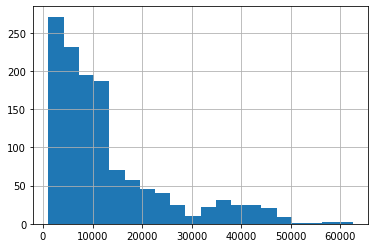

In [15]:
dataframe.charges.hist(bins=20)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


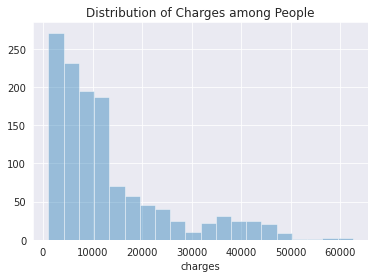

In [16]:
import seaborn as sns
sns.set_style('darkgrid')
plt.title('Distribution of Charges among People')
sns.distplot(dataframe.charges, bins=20, kde=False);


Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

In [0]:
jovian.commit(project=project_name, environment=None)

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [0]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [18]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[62.    ,  1.    , 36.278 ,  0.    ,  0.    ],
        [40.    ,  1.    , 40.4393,  0.    ,  0.    ],
        [19.    ,  1.    , 34.338 ,  0.    ,  0.    ],
        ...,
        [19.    ,  1.    , 20.079 ,  0.    ,  0.    ],
        [23.    ,  0.    , 35.5699,  2.    ,  1.    ],
        [24.    ,  0.    , 26.772 ,  0.    ,  0.    ]]),
 array([[12719.77084  ],
        [ 5329.974118 ],
        [ 1237.98402  ],
        ...,
        [ 1217.95968  ],
        [37741.395734 ],
        [18576.1157666]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [0]:
# Import from numpy arrays to pytorch
inputs = torch.from_numpy(inputs_array).type(torch.float32)
targets = torch.from_numpy(targets_array).type(torch.float32)

In [20]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [0]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets. **

In [0]:
val_percent = 0.2 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [0]:
batch_size = 64

In [0]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)

Let's look at a batch of data to verify everything is working fine so far.

In [26]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[18.0000,  0.0000, 32.1604,  0.0000,  0.0000],
        [30.0000,  1.0000, 36.6660,  2.0000,  1.0000],
        [18.0000,  1.0000, 32.3301,  0.0000,  0.0000],
        [26.0000,  0.0000, 27.9214,  0.0000,  0.0000],
        [41.0000,  0.0000, 31.6220,  3.0000,  0.0000],
        [19.0000,  0.0000, 17.2660,  0.0000,  0.0000],
        [20.0000,  1.0000, 26.4810,  0.0000,  1.0000],
        [53.0000,  1.0000, 25.6177,  2.0000,  0.0000],
        [31.0000,  0.0000, 24.9678,  0.0000,  0.0000],
        [45.0000,  1.0000, 22.2082,  0.0000,  1.0000],
        [44.0000,  1.0000, 26.5780,  2.0000,  0.0000],
        [60.0000,  0.0000, 31.4765,  0.0000,  1.0000],
        [49.0000,  1.0000, 25.0648,  2.0000,  1.0000],
        [49.0000,  0.0000, 41.3996,  2.0000,  0.0000],
        [57.0000,  0.0000, 36.8600,  2.0000,  0.0000],
        [55.0000,  0.0000, 26.1706,  0.0000,  0.0000],
        [20.0000,  1.0000, 30.1961,  2.0000,  0.0000],
        [18.0000,  1.0000, 33.0770,  0.0000,  0.0000],
  

Let's save our work by committing to Jovian.

In [0]:
jovian.commit(project=project_name, environment=None)

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [27]:
input_size = len(input_cols)
output_size = len(output_cols)
input_cols, output_cols

(array(['age', 'sex', 'bmi', 'children', 'smoker'], dtype=object),
 array(['charges'], dtype=object))

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [0]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                  # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)                          # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                           # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [0]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [49]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0231, -0.3502,  0.2735, -0.0855,  0.3222]], requires_grad=True),
 Parameter containing:
 tensor([-0.4010], requires_grad=True)]

One final commit before we train the model.

In [0]:
jovian.commit(project=project_name, environment=None)

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [0]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [32]:
print(model)

InsuranceModel(
  (linear): Linear(in_features=5, out_features=1, bias=True)
)


In [51]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 13553.74609375}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [52]:
epochs = 1000
lr = 1e-4
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 13475.4482
Epoch [40], val_loss: 13397.1494
Epoch [60], val_loss: 13318.8457
Epoch [80], val_loss: 13240.5430
Epoch [100], val_loss: 13162.2422
Epoch [120], val_loss: 13083.9434
Epoch [140], val_loss: 13005.6406
Epoch [160], val_loss: 12927.3418
Epoch [180], val_loss: 12849.0449
Epoch [200], val_loss: 12770.7441
Epoch [220], val_loss: 12692.4434
Epoch [240], val_loss: 12614.1465
Epoch [260], val_loss: 12535.8438
Epoch [280], val_loss: 12457.5449
Epoch [300], val_loss: 12379.2441
Epoch [320], val_loss: 12300.9805
Epoch [340], val_loss: 12222.8184
Epoch [360], val_loss: 12144.6934
Epoch [380], val_loss: 12067.3232
Epoch [400], val_loss: 11990.2012
Epoch [420], val_loss: 11913.3164
Epoch [440], val_loss: 11836.7021
Epoch [460], val_loss: 11760.4404
Epoch [480], val_loss: 11684.2500
Epoch [500], val_loss: 11608.5137
Epoch [520], val_loss: 11533.5605
Epoch [540], val_loss: 11458.8867
Epoch [560], val_loss: 11384.6699
Epoch [580], val_loss: 11310.9531
Epoch [600], val_l

In [53]:
epochs = 1000
lr = 1e-2
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7657.4648
Epoch [40], val_loss: 7499.7197
Epoch [60], val_loss: 7455.1768
Epoch [80], val_loss: 7417.1582
Epoch [100], val_loss: 7381.5039
Epoch [120], val_loss: 7346.8115
Epoch [140], val_loss: 7314.0674
Epoch [160], val_loss: 7283.4990
Epoch [180], val_loss: 7254.3384
Epoch [200], val_loss: 7225.5361
Epoch [220], val_loss: 7198.2505
Epoch [240], val_loss: 7175.1509
Epoch [260], val_loss: 7154.4297
Epoch [280], val_loss: 7134.3896
Epoch [300], val_loss: 7117.7461
Epoch [320], val_loss: 7104.9004
Epoch [340], val_loss: 7096.4375
Epoch [360], val_loss: 7090.2905
Epoch [380], val_loss: 7086.5215
Epoch [400], val_loss: 7083.3906
Epoch [420], val_loss: 7081.4790
Epoch [440], val_loss: 7080.0078
Epoch [460], val_loss: 7079.0176
Epoch [480], val_loss: 7078.7197
Epoch [500], val_loss: 7078.3394
Epoch [520], val_loss: 7077.7734
Epoch [540], val_loss: 7077.5547
Epoch [560], val_loss: 7077.8687
Epoch [580], val_loss: 7077.9863
Epoch [600], val_loss: 7078.1909
Epoch [620], v

In [54]:
epochs = 1000
lr = 5e-1
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7071.9561
Epoch [40], val_loss: 7043.0234
Epoch [60], val_loss: 7024.7290
Epoch [80], val_loss: 7007.8423
Epoch [100], val_loss: 7013.8643
Epoch [120], val_loss: 6986.7788
Epoch [140], val_loss: 6977.8584
Epoch [160], val_loss: 7032.0693
Epoch [180], val_loss: 6979.8550
Epoch [200], val_loss: 6947.1348
Epoch [220], val_loss: 6939.8018
Epoch [240], val_loss: 6931.2817
Epoch [260], val_loss: 6920.8682
Epoch [280], val_loss: 6914.5791
Epoch [300], val_loss: 6902.9253
Epoch [320], val_loss: 6894.7539
Epoch [340], val_loss: 6896.7236
Epoch [360], val_loss: 6884.0210
Epoch [380], val_loss: 6873.5635
Epoch [400], val_loss: 6863.2539
Epoch [420], val_loss: 6852.7500
Epoch [440], val_loss: 6847.7720
Epoch [460], val_loss: 6835.2417
Epoch [480], val_loss: 6832.8447
Epoch [500], val_loss: 6820.7344
Epoch [520], val_loss: 6827.4648
Epoch [540], val_loss: 6820.8887
Epoch [560], val_loss: 6797.4736
Epoch [580], val_loss: 6789.7119
Epoch [600], val_loss: 6787.8438
Epoch [620], v

In [55]:
epochs = 1000
lr = 1
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6613.0420
Epoch [40], val_loss: 6601.3003
Epoch [60], val_loss: 6667.5146
Epoch [80], val_loss: 6586.3213
Epoch [100], val_loss: 6570.4380
Epoch [120], val_loss: 6539.3350
Epoch [140], val_loss: 6544.5952
Epoch [160], val_loss: 6516.3950
Epoch [180], val_loss: 6563.1504
Epoch [200], val_loss: 6483.0547
Epoch [220], val_loss: 6485.2285
Epoch [240], val_loss: 6452.1240
Epoch [260], val_loss: 6445.9229
Epoch [280], val_loss: 6451.2461
Epoch [300], val_loss: 6412.2324
Epoch [320], val_loss: 6397.2051
Epoch [340], val_loss: 6549.6338
Epoch [360], val_loss: 6366.2681
Epoch [380], val_loss: 6354.4346
Epoch [400], val_loss: 6343.2754
Epoch [420], val_loss: 6361.6670
Epoch [440], val_loss: 6333.1797
Epoch [460], val_loss: 6303.2935
Epoch [480], val_loss: 6357.1479
Epoch [500], val_loss: 6283.0928
Epoch [520], val_loss: 6252.8818
Epoch [540], val_loss: 6254.2197
Epoch [560], val_loss: 6231.3643
Epoch [580], val_loss: 6221.4634
Epoch [600], val_loss: 6422.3433
Epoch [620], v

In [56]:
epochs = 1000
lr = 1.5
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6285.5283
Epoch [40], val_loss: 5868.5391
Epoch [60], val_loss: 6202.5425
Epoch [80], val_loss: 5915.1094
Epoch [100], val_loss: 5875.4717
Epoch [120], val_loss: 5781.9307
Epoch [140], val_loss: 5774.8711
Epoch [160], val_loss: 5948.8096
Epoch [180], val_loss: 5771.3701
Epoch [200], val_loss: 6243.7588
Epoch [220], val_loss: 6119.3564
Epoch [240], val_loss: 5831.8535
Epoch [260], val_loss: 5723.8511
Epoch [280], val_loss: 6076.7041
Epoch [300], val_loss: 5878.7817
Epoch [320], val_loss: 5582.2393
Epoch [340], val_loss: 5577.1768
Epoch [360], val_loss: 5544.4268
Epoch [380], val_loss: 5541.4990
Epoch [400], val_loss: 5556.8271
Epoch [420], val_loss: 5874.5586
Epoch [440], val_loss: 5885.4912
Epoch [460], val_loss: 5649.6294
Epoch [480], val_loss: 5528.3789
Epoch [500], val_loss: 5475.9932
Epoch [520], val_loss: 5388.3608
Epoch [540], val_loss: 5624.4365
Epoch [560], val_loss: 5371.6455
Epoch [580], val_loss: 5309.9131
Epoch [600], val_loss: 5776.3662
Epoch [620], v

In [57]:
epochs = 1000
lr = 2
history6 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 5658.0117
Epoch [40], val_loss: 5079.6426
Epoch [60], val_loss: 5161.0479
Epoch [80], val_loss: 6207.3643
Epoch [100], val_loss: 4859.5063
Epoch [120], val_loss: 4869.0410
Epoch [140], val_loss: 4732.9600
Epoch [160], val_loss: 6208.2100
Epoch [180], val_loss: 4931.7939
Epoch [200], val_loss: 5862.0303
Epoch [220], val_loss: 4663.0376
Epoch [240], val_loss: 5505.8857
Epoch [260], val_loss: 6048.0371
Epoch [280], val_loss: 5949.5103
Epoch [300], val_loss: 5982.9189
Epoch [320], val_loss: 4698.3086
Epoch [340], val_loss: 5812.0488
Epoch [360], val_loss: 4545.7202
Epoch [380], val_loss: 4911.4736
Epoch [400], val_loss: 5635.0049
Epoch [420], val_loss: 4517.5703
Epoch [440], val_loss: 5805.7568
Epoch [460], val_loss: 5603.4512
Epoch [480], val_loss: 5808.4238
Epoch [500], val_loss: 4441.4961
Epoch [520], val_loss: 4415.6128
Epoch [540], val_loss: 5762.8052
Epoch [560], val_loss: 5124.3359
Epoch [580], val_loss: 4402.8447
Epoch [600], val_loss: 4959.4922
Epoch [620], v

In [58]:
epochs = 1000
lr = 1
history7 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 4272.6113
Epoch [40], val_loss: 4277.5786
Epoch [60], val_loss: 4257.5186
Epoch [80], val_loss: 4248.1040
Epoch [100], val_loss: 4714.2856
Epoch [120], val_loss: 4296.6328
Epoch [140], val_loss: 4356.5957
Epoch [160], val_loss: 4550.9014
Epoch [180], val_loss: 4310.6641
Epoch [200], val_loss: 4257.8916
Epoch [220], val_loss: 4249.2544
Epoch [240], val_loss: 4260.9253
Epoch [260], val_loss: 4227.6143
Epoch [280], val_loss: 4339.1689
Epoch [300], val_loss: 4247.7686
Epoch [320], val_loss: 4448.1152
Epoch [340], val_loss: 4366.7681
Epoch [360], val_loss: 4411.1958
Epoch [380], val_loss: 4313.8755
Epoch [400], val_loss: 4410.1675
Epoch [420], val_loss: 4254.7090
Epoch [440], val_loss: 4301.8555
Epoch [460], val_loss: 4302.1997
Epoch [480], val_loss: 4369.5166
Epoch [500], val_loss: 4208.1533
Epoch [520], val_loss: 4329.1875
Epoch [540], val_loss: 4308.5972
Epoch [560], val_loss: 4460.3408
Epoch [580], val_loss: 4345.0044
Epoch [600], val_loss: 4250.3906
Epoch [620], v

In [59]:
epochs = 1000
lr = 5e-1
history8 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 4176.5391
Epoch [40], val_loss: 4175.2148
Epoch [60], val_loss: 4177.2324
Epoch [80], val_loss: 4184.0234
Epoch [100], val_loss: 4240.1230
Epoch [120], val_loss: 4198.7764
Epoch [140], val_loss: 4175.8955
Epoch [160], val_loss: 4229.0854
Epoch [180], val_loss: 4181.8853
Epoch [200], val_loss: 4183.8545
Epoch [220], val_loss: 4195.9604
Epoch [240], val_loss: 4196.9585
Epoch [260], val_loss: 4170.7715
Epoch [280], val_loss: 4194.2710
Epoch [300], val_loss: 4181.2065
Epoch [320], val_loss: 4178.7412
Epoch [340], val_loss: 4180.0361
Epoch [360], val_loss: 4169.7480
Epoch [380], val_loss: 4188.4941
Epoch [400], val_loss: 4169.0298
Epoch [420], val_loss: 4202.5098
Epoch [440], val_loss: 4173.5566
Epoch [460], val_loss: 4167.0801
Epoch [480], val_loss: 4166.2661
Epoch [500], val_loss: 4166.7705
Epoch [520], val_loss: 4166.6260
Epoch [540], val_loss: 4167.5503
Epoch [560], val_loss: 4171.9399
Epoch [580], val_loss: 4171.4956
Epoch [600], val_loss: 4179.3843
Epoch [620], v

In [60]:
epochs = 1000
lr = 2e-1
history9 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 4161.1733
Epoch [40], val_loss: 4160.6206
Epoch [60], val_loss: 4160.1230
Epoch [80], val_loss: 4157.6221
Epoch [100], val_loss: 4158.6919
Epoch [120], val_loss: 4165.9199
Epoch [140], val_loss: 4157.4727
Epoch [160], val_loss: 4161.4189
Epoch [180], val_loss: 4169.5156
Epoch [200], val_loss: 4157.7754
Epoch [220], val_loss: 4158.8599
Epoch [240], val_loss: 4158.8887
Epoch [260], val_loss: 4161.7651
Epoch [280], val_loss: 4157.4106
Epoch [300], val_loss: 4166.3359
Epoch [320], val_loss: 4156.6016
Epoch [340], val_loss: 4166.4414
Epoch [360], val_loss: 4162.2886
Epoch [380], val_loss: 4159.0400
Epoch [400], val_loss: 4157.3462
Epoch [420], val_loss: 4163.1162
Epoch [440], val_loss: 4159.0767
Epoch [460], val_loss: 4156.1450
Epoch [480], val_loss: 4155.8540
Epoch [500], val_loss: 4171.4746
Epoch [520], val_loss: 4155.5103
Epoch [540], val_loss: 4155.4346
Epoch [560], val_loss: 4165.1973
Epoch [580], val_loss: 4156.5488
Epoch [600], val_loss: 4159.4106
Epoch [620], v

**Q: What is the final validation loss of your model?**

In [61]:
epochs = 1000
lr = 2e-1
history10 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 4153.4014
Epoch [40], val_loss: 4154.2319
Epoch [60], val_loss: 4152.9307
Epoch [80], val_loss: 4155.8486
Epoch [100], val_loss: 4152.8604
Epoch [120], val_loss: 4157.4268
Epoch [140], val_loss: 4154.3638
Epoch [160], val_loss: 4155.9189
Epoch [180], val_loss: 4153.1162
Epoch [200], val_loss: 4152.9043
Epoch [220], val_loss: 4159.1616
Epoch [240], val_loss: 4159.2158
Epoch [260], val_loss: 4152.9443
Epoch [280], val_loss: 4152.0244
Epoch [300], val_loss: 4155.5752
Epoch [320], val_loss: 4163.6357
Epoch [340], val_loss: 4152.0205
Epoch [360], val_loss: 4151.7759
Epoch [380], val_loss: 4157.4058
Epoch [400], val_loss: 4152.0352
Epoch [420], val_loss: 4158.2617
Epoch [440], val_loss: 4152.0059
Epoch [460], val_loss: 4155.2515
Epoch [480], val_loss: 4153.6431
Epoch [500], val_loss: 4153.7139
Epoch [520], val_loss: 4151.9150
Epoch [540], val_loss: 4151.4087
Epoch [560], val_loss: 4154.5576
Epoch [580], val_loss: 4151.0142
Epoch [600], val_loss: 4151.2515
Epoch [620], v

In [62]:
val_loss = history8[-1]
print('The final validation loss is: ', val_loss)

The final validation loss is:  {'val_loss': 4158.900390625}


Text(0, 0.5, 'losses')

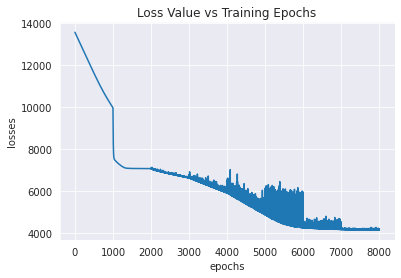

In [63]:
whole_history = [result] + history1 + history2 + history3 + history4 + history5 + history6 + history7 + history8 
losses = [r['val_loss'] for r in whole_history]

plt.plot(losses)
plt.grid('on')
plt.title('Loss Value vs Training Epochs')
plt.xlabel('epochs')
plt.ylabel('losses')

Let's log the final validation loss to Jovian and commit the notebook

In [0]:
jovian.log_metrics(val_loss=val_loss)

In [0]:
jovian.commit(project=project_name, environment=None)

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [0]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(input)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [65]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([21.0000,  1.0000, 34.4641,  0.0000,  0.0000])
Target: tensor([1501.8203])
Prediction: tensor(1748.9500)


In [66]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([24.0000,  0.0000, 24.5119,  0.0000,  0.0000])
Target: tensor([2983.3291])
Prediction: tensor(2887.0125)


In [68]:
input, target = val_ds[25]
predict_single(input, target, model)

Input: tensor([41.0000,  0.0000, 30.0894,  0.0000,  0.0000])
Target: tensor([6061.6143])
Prediction: tensor(7297.3525)


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to clean up & replicate this notebook (or [this one](https://jovian.ml/aakashns/housing-linear-minimal), or [this one](https://jovian.ml/aakashns/mnist-logistic-minimal) ) for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patters in machine learning from problem-specific details.

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ml/forum/t/share-your-work-here-assignment-2/4931

In [0]:
jovian.commit(project=project_name, environment=None)
jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes